# Convective fit all
averaged over the last portion of the simulation



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## This function loads all runs and calculates quantities necessary for comparing the scaling analysis.

In [15]:
#%% Pick the filename and path
files = [
 #        '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LOWV.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5',

            '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5',
             '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5',
#         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p005/snapshots/snapshots_1e-5_0p005.h5',
#         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2.h5',
#        '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V5/snapshots/snapshots_1e-5_0p02_V5.h5',

         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p01/snapshots/snapshots_1e-7_0p01.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5',
         #'/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_orig.h5'
        ]


molec = 0 # Flag (0,1) for including subgrid terms in finding zeros of vertical buoyancy flux

factor = []
ydata = []
hntotal = []
Htotal = []
vbf = []
vpwp = []
vpwpscale = []
enttotal = []
betatotal = []
vpwpa = []
vbfa = []
test = []
MOdepth =[]
Ball =[]
ustartotal = []
S2a=[]
EBFa=[]
flagfirst = True
for filename in files:
    print(filename)
    f = h5py.File(filename, 'r')
    print('Loaded')
    # Get the data
    data = list(f['tasks'])

    # Basic parameters
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    print(f'Processing N = {N}, theta = {tht}')

    # Load variables in physical space
    b = f['tasks']['b'] # Perturbation buoyancy
    v = f['tasks']['v'] # Along-slope direction
    u = f['tasks']['u'] # Along-slope direction

    vbfr = f['tasks']['VBFrotated']
    VPWP = f['tasks']['GSProtated'][:,:,:]*1e-4/(N**2*np.sin(tht))
    #vbfrot = f['tasks']['VBFrotated']
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    q = f['tasks']['PV']
    wq = f['tasks']['wq']
    print('Begin calcs')
    qm = np.mean(q, axis=1)
    Qo = 1e-4*N**2
    vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
    uz = np.gradient(np.mean(u, axis=1), axis=-1)/np.gradient(z)
    bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
    # Calculate BEk
    tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
    taux = -1035*1e-4*uz[:,0]
    
    S2 = N**2*tht**2/1e-8
    Bek = -(tauy/(1030*1e-4)*N**2*np.sin(tht) - molec*1e-4*N**2)/(1+S2)

    # Calculate h
    print('Calculations Complete')
    
    nt = time.size
    avgt = 18*2
    for i in range(1, nt-avgt+1, avgt):
        ti = range(i, i+avgt)
        #Average the vert buoyancy flux (molec turns on subgrid terms)
        vsmooth = np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:]), axis=0)
        #inds = np.where(np.diff(np.sign(vsmooth)) <0)[0]
        #inds = np.where(vsmooth>0)[-1] # shallowest point where w'b'>0

        qsmooth = integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)/z # running integral average of q
        qmean = np.mean(qm[ti,:], axis=0) #direct calculation of Q
        
        # Try a direct calculation of H and entrainment
        # Options are to define relative to Qo or as the place the PV flux is 0 (noisy?)
        # indq = np.where(qmean)>(0.*Qo))[0][0]
        qflux = np.mean(wq[ti,:], axis=0)
        indq = np.where(qmean>0.9*Qo)[0][0] 
        #indq = np.where(qmean>0.1*Qo)[0][0]
    #   indq = np.where(np.logical_and(np.mean(wq[ti,0,:], axis=0)>=0, z>10))[0][0]
    
        H = z[indq] # pick out H
        ent = np.mean(vbfr[ti,0,indq] - 1e-4*(bz[ti,indq])) #these are the buoyancy entrainment fluxes at this depth
        betatotal.append( np.mean(VPWP[ti,0,indq]-molec*1e-4*vz[ti,indq], axis=0))
        # Find where h is (where vert. buoyancy flux is 0)
        inds = np.where(np.logical_and(vsmooth<0, z<=H))[0]
        #inds = np.where(np.logical_and(vsmooth<0, np.logical_and(z<=H, z>10)))[0] # Note ad hoc use of z>10...
        if inds.size == 0:
            print('No Ind: ' + filename)
            hn = H
        else:
            #inds = [inds[-1]]
            inds = [inds[0]]
            hn = z[inds[0]]

            Beka = np.mean(Bek[ti])
            Ha = H
            ha = hn
            #factorPartial = (1+S2)*Beka**2/(Ha*0.1**3)*(1e-4/(N**2*np.tan(tht)))**3 # v' ~ V h/H
            ustar = np.sqrt(np.abs(np.mean((1*taux + 1j*tauy)[ti], axis=0)/1035))
            ustartotal.append(ustar)
            factorPartial = Beka**2/(ustar**3*Ha)*(1e-4*(1+S2)/(N**2*tht))**3 # THIS ONE WORKS FAIRLY WELL
            
            factorPartial = (ustar*1e-4*(1+S2)/(Ha*N**2*tht))**4
            #factorPartial = Beka**2/(0.1**3*Ha)*(1e-4*(1+S2)/(N**2*tht))**3
            
            ydataPartial = ha/Ha     #y is the ratio of h/H
            entPartial = 1 - ent/Beka # Define the entrainment factor 

            # Some options for defining the velocity scale 
            # include interior velocity, friction velocity, or interior velocity normalized by h/H
#             valt = hn*(1e-4*S2/np.tan(tht[0,0,0])/(1+S2))
            valt = 0.1
#             valt = np.mean(np.sqrt(np.abs(tauy[ti])/1030))
            
            vpwpscale.append((Beka*(ha))**(1/3)*(ha)*N**2*tht/((1+S2)*1e-4)) # Save a scaling estimate
            #vpwpscale.append((Beka*ha)**(1/3)*ustar)
            #vpwpscale.append(ustar**2)
            #vpwpscale.append(0.4*(0*1.26*ustar**3 + 8.38*0.4*0.1*Beka*ha)**(1/3)*ustar) #KPP scaling from Large et al. 1994
            #vpwpscale.append(0.4*(0*1.26*ustar**3 + 8.38*0.4*0.1*Beka*ha)**(1/3)*0.1) #KPP scaling from Large et al. 1994
            
            #vpwpscale.append((-Beka*ha)**(1/3)*ha*N**2*tht/1e-4) # Save a scaling estimate
            
            #vpwpscale.append((-Beka*Ha)**(1/3)*ustar)
            #vpwpscale.append((-Beka*Ha)**(1/3)*Ha*N**2*tht/1e-4)
            #vpwpscale.append(ustar*ha/((1+S2)*ustar*1e-4/(0.4*tht*N**2))*0.1*0.4)
            #vpwpscale.append((Beka*(1+S2)*(1-ydataPartial))*1e-4/(N**2*tht))# Assuming N^2*tht/f*<v'w'> ~ Bek*(z+H)/H
            #vpwpscale.append(np.mean(tauy[ti]/1030)*(1-ydataPartial))
            #vpwpscale.append((-Beka*ha)**(1/3)*0.1*(1-ydataPartial))
            vpwp.append(np.mean(VPWP[ti,0,inds[0]]-molec*1e-4*vz[ti,inds[0]], axis=0))

            enttotal.append(entPartial)
            factor.append( factorPartial)
            ydata.append(ydataPartial)
            hntotal.append(ha)
            Htotal.append(Ha)
            S2a.append(S2)
            
            vbfa.append(np.mean(vbfr[ti,0,:], axis=0)) #slope normal buoyancy flux
            vpwpa.append(np.mean(VPWP[ti,0,:],axis=0))
            MOdepth.append((1+S2)*ustar*1e-4/(0.4*tht*N**2))
            #test.append(np.sqrt(np.abs(np.mean(tauy[ti]))/1030))
            #test.append((np.mean(np.abs(tauy[ti]))/(1030*(1+S2)))**2*1e-4/(N**2*tht*0.1**3))
            #test.append(N**2*tht*valt*(-Beka*Ha)**(1/3)/1e-4)
            test.append(N**2*tht/(1e-4)/(1+S2))
            Ball.append(Beka)
            if flagfirst:
                vbf = np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:]), axis=0)[:,np.newaxis]
                flagfirst = False
            else:
                vbf = np.concatenate((vbf,np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:]), axis=0)[:,np.newaxis]), axis=-1)
    f.close()

factor = np.array(factor)
ydata = np.array(ydata)
hntotal = np.array(hntotal)
Htotal = np.array(Htotal)
test = np.array(test)
Ball = np.array(Ball)
vpwp = np.array(vpwp)
enttotal = np.array(enttotal)
ustartotal = np.array(ustartotal)
S2a  = np.array(S2a)
betatotal = np.array(betatotal)

/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.05
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.019999999999999997
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.0225
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5
Loaded
Processing N = 0.00223606797749979, theta = 0.019999999999999997
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5
Loaded
Processing N = 0.00031622776601683794, theta = 0.004999999999999999
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DN

In [16]:
factor = np.array(factor)
ydata = np.array(ydata)
hntotal = np.array(hntotal)
Htotal = np.array(Htotal)
test = np.array(test)
Ball = np.array(Ball)
vpwp = np.array(vpwp)
enttotal = np.array(enttotal)
ustartotal = np.array(ustartotal)
S2a  = np.array(S2a)
betatotal = np.array(betatotal)

In [ ]:
plt.plot(ydata)
plt.plot(S2a)
plt.ylim(0,1)

In [ ]:
plt.plot(ustartotal)
plt.plot(np.sqrt(2e-3)*(0.1 - test*Htotal)*np.sqrt(ydata))

## Check $\langle v'w' \rangle$ scaling

Slope: 0.05566175955517052 Intercept = -2.3511588960209925e-06


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


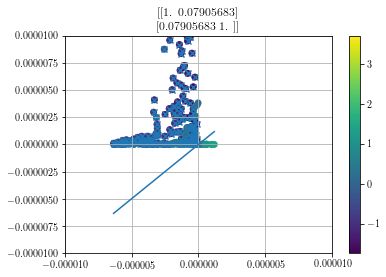

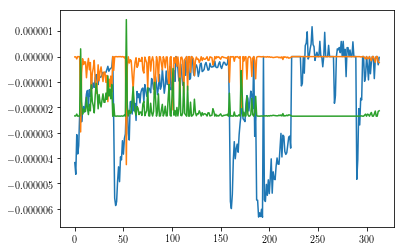

In [116]:
plt.figure()
#num = np.mean(np.array(vpwpa)**(1), axis=1)
num = vpwp
#scale = -(np.array(vpwpscale)*(1-ydata*0.4*ustartotal/1e-4/Htotal))
scale =   (np.array(vpwpscale))
wstar = np.array(vpwpscale/test)
scale = np.array(vpwpscale)
scale = Ball*(1-0.4*ydata-1.2*ydata**2)/test - 0*ustartotal**3/(0.4*ydata*Htotal)*(1-ydata-ydata**2)/test
scale = (Htotal*ydata)**2*(0.3-ydata)**2*test**2
#scale = (0.1 - test*Htotal)**2
#scale = np.array(vpwpscale)
#scale = (ustartotal**6 + np.array(vpwpscale)**3)**(1/3)
#scale = -ustartotal**2*(1-ydata)
plt.scatter(num, scale, c=np.log10(MOdepth/(Htotal)))
plt.colorbar()
mask = np.logical_and(MOdepth/(Htotal)<1, ydata>5e-3)
plt.scatter(np.array(num)[mask], np.array(scale)[mask], marker='x')

# plt.plot(num, num)
corr = np.corrcoef(np.array(num)[mask], np.array(scale)[mask])
plt.title(corr**2)
plt.grid()
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(scale)[mask], np.array(num)[mask])
a, _, _, _ = np.linalg.lstsq(np.array(scale)[mask,np.newaxis], np.array(num)[mask])
xl = 1e-5
plt.ylim(-xl, xl)
plt.xlim(-xl, xl)
print('Slope: '+str(slope) +' Intercept = ' + str(intercept))
plt.plot([np.min(num), np.max(num)], [np.min(num), np.max(num)])
plt.figure()
plt.plot(num)
plt.plot(a*scale)
plt.plot(slope*scale + intercept)
#plt.ylim(np.min(num), np.max(num))
#plt.plot([-xl, xl], a*[-xl, xl], marker='d', linestyle='-')

## Case of direct solve (ie no optimization needed)

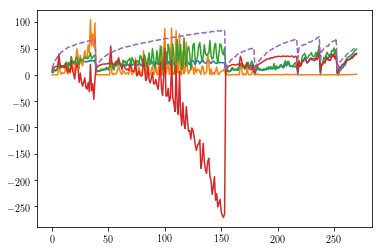

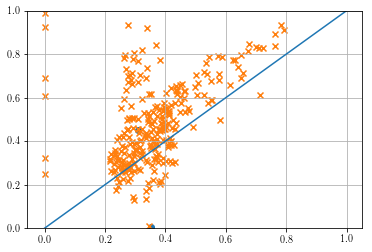

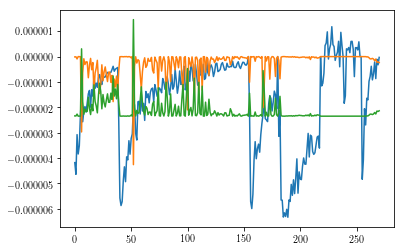

In [143]:
mask = np.logical_and(MOdepth/(Htotal) < 100, ydata>5e-4)

plt.plot(ydata[mask]*Htotal[mask])
co = a
en = enttotal*1
plt.plot((-co*test[mask]*scale[mask]/Ball[mask])*Htotal[mask]/en[mask])
plt.plot( (1 + vpwp[mask]*test[mask]/Ball[mask])*Htotal[mask]/en[mask])
plt.plot((1+slope*scale[mask]*test[mask]/Ball[mask]+intercept*test[mask]/Ball[mask])*Htotal[mask]/en[mask])

plt.plot(Htotal[mask], linestyle='--')

plt.figure()
plt.scatter(ydata[mask], (1+slope*scale[mask]*test[mask]/Ball[mask]+intercept*test[mask]/Ball[mask])*Htotal[mask]/en[mask], marker='o')
#plt.scatter(ydata[mask], -co*scale[mask]*test[mask]/Ball[mask]/enttotal[mask])
plt.scatter(ydata[mask], (1 + vpwp[mask]*test[mask]/Ball[mask])/en[mask], marker='x')

plt.plot([0,1], [0,1])
plt.grid()
plt.ylim(0,1)

plt.figure()
plt.plot(vpwp[mask])
plt.plot(co*scale[mask])
plt.plot(slope*scale[mask] + intercept)

## Check how well h is reproduced using numerical values of $\langle v' w' \rangle$

(0, 100)

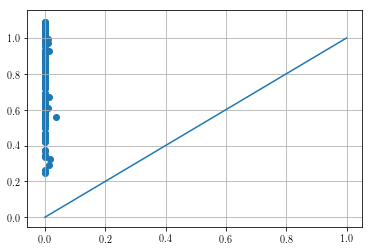

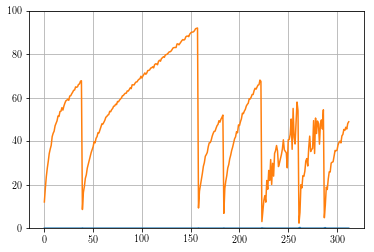

In [195]:
# Check how well h/H is reproduced using numerical values of <v'w'>
mask = MOdepth/(Htotal) < 1000
nums = (1 + vpwp[mask]*test[mask]/Ball[mask])/(enttotal[mask])
plt.scatter(ydata[mask], nums)
plt.plot([0,1], [0,1])
plt.grid()

plt.figure()
plt.plot(ydata[mask]*Htotal[mask])
plt.plot( nums*Htotal[mask])
plt.grid()
plt.ylim(0, 100)

## Define optimization function

In [5]:
def fithT(ent, H, S2,ustar):
    def fithH(factor, C, I): #factor is the combined coefficient of the highest order term (ie. Factor*(1-h/h)^3)
        nt = factor.size
        h = np.ones((nt))
        entm = np.mean(ent)
        for i in range(0, nt):
            def f(x):
#                return x - C*factor[i]*(1-ent[i]*x)**3 + I # Assumes v'w' ~ ustar*wstar
                 #return x**(-1)*(I+x)*(1-x) - C*factor[i]*(1-ent[i]*x) 
#                 return x*(I - x) - C*factor[i]*(1-ent[i]*x)
#                return (x)**4- C**3*factor[i]**4*(1-ent[i]*x)**3 - I**3 # Assumes v'w' ~ Delta u_g * wstar
#                return (x/(1+I*x))**4 -C**3*factor[i]**4*(1-ent[i]*x)**3
              return (x-I)**2 - C*factor[i]**2*(1-ent[i]*x)
#               return (I*factor[i] + x)**2 - C**2*factor[i]**2*(1-ent[i]*x)
#                return (x - I)**4 - C**4*factor[i]**4*(1-ent[i]*x)**3
#                return (x-I)**4 - C**3*factor[i]**4*(1-ent[i]*x)**3
#                return x**4*(1-I*x)**6 - C**3*factor[i]**4*(1-ent[i]*x)**3
#                return x**2*factor[i]**(-2) + x*factor[i]**(-1) + I - C**3*(1-ent[i]*x)**3
#                return (1+S2[i])**3*x**4- C**3*factor[i]**4*(1-(1e-4*1e-5/EBF[i] + ent[i])*x)**3 
                # return I**3*x**3 +x**4 - C**3*factor[i]**4*(1-ent[i]*x)**3
                #return x-3*x**2 - C*factor[i]*(1-ent[i]*x)**3 + I
                #return  C*factor[i]*(1-ent[i]*x)**3 + factor[i] *I
#return I**3 - C**3*(1-ent[i]*x)**3 
                #return 0*I*x*factor[i] + x**2 - C**3*factor[i]*(1-ent[i]*x)**3

                #return 1 - C**3*factor[i]*(1-ent[i]*x)**3 + 0
            
            if np.isfinite(factor[i]):
                #sol = optimize.root(f, [0.3, 0.8], method='lm')
                ##sol = optimize.root_scalar(f,x0=0.5)
                #if not sol.success:
                #    print('fail')
                #else:
                    #print(np.sort(sol.x))
                #    h[i] = (np.sort(sol.x)[1])
                h[i], info, ier, n = optimize.fsolve(f, 0.34, maxfev=10000, full_output=True)
                if ier == 0:
                    print('fail')
        return h*H
    return fithH


## Optimize for the coefficient in the cubic equation

In [9]:
# Optimize for H
mask = np.logical_and(MOdepth/(Htotal) < 100000, ydata>1e-3)
en = enttotal
Hop = Htotal
fact = np.array(MOdepth/Htotal)
#fact = 0.1/(Htotal*test)
#fact = np.array(MOdepth)**(-1)
#fact = np.array(MOdepth)
#fact = factor
#Hop = 1 + 0*Htotal
popt, pcov = optimize.curve_fit(fithT(en[mask], Hop[mask], S2a[mask], ustartotal[mask]),fact[mask], ydata[mask]*Hop[mask], p0=[10,0.4],
                                absolute_sigma=False, bounds=[[-100, -100], [1e10, 1e10]])
print(popt)
print(pcov)

[0.09438293 0.2935979 ]
[[ 8.79860741e-04 -8.26018153e-05]
 [-8.26018153e-05  2.87809536e-05]]


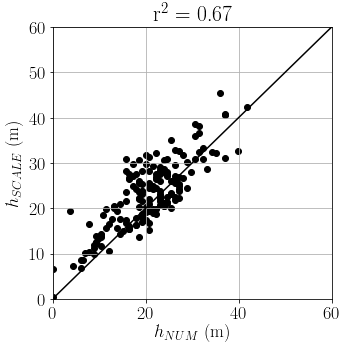

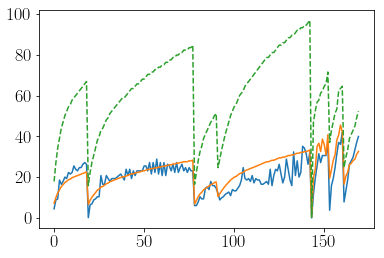

In [22]:
mask =  np.logical_and(MOdepth/(Htotal) < 100000, ydata>2e-3)
Hop = Htotal
en = enttotal
fact = np.array(MOdepth/Htotal)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

#print(np.corrcoef(np.array(hntotal), y = fitn(en, Htotal)(np.array(factor), popt[0]))**2)
# plt.scatter(np.array(hntotal)/np.array(Htotal), fitH(np.array(factor), poptl[0]))
fitt = fithT(en, Hop, S2a, ustartotal)(fact, 0.1, 0.33)/Hop
plt.figure(figsize=(5,5))
plt.scatter(np.array(ydata)[mask]*Hop[mask], fitt[mask]*Hop[mask], color='k')
corr = np.corrcoef(np.array(ydata*Hop)[mask], np.array(fitt*Hop)[mask])
plt.title(f'r$^2$ = {corr[1,0]**2:.2}')
plt.plot([0, np.max(Hop)], [0, np.max(Hop)], color='k')
plt.ylim(0, 60); plt.xlim(0, 60)
plt.xlabel('$h_{NUM}$ (m)')
plt.ylabel('$h_{SCALE}$ (m)')
plt.grid()

#plt.savefig('./MSFigs/ConvTheory.pdf', bbox_inches='tight')

plt.figure()
plt.plot((ydata*Hop)[mask])
plt.plot((fitt*Hop)[mask])
#plt.plot((1-popt[1]/popt[0])*Hop[mask])
plt.plot(Hop[mask], linestyle='--')


In [238]:
mask = np.logical_and(MOdepth/Htotal<1, ydata>5e-3)
plt.scatter( np.array((ydata)[mask]),()[mask], c=np.array(MOdepth)[mask])
plt.grid()
plt.colorbar()
#plt.ylim(-10, 5)
#plt.xlim(-10, 10)

TypeError: only integer scalar arrays can be converted to a scalar index

# Extras

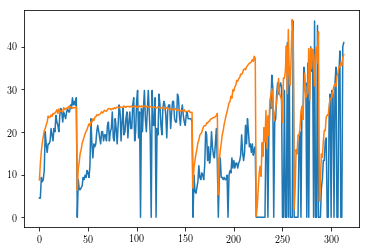

In [157]:
plt.plot(ydata*Htotal)
plt.plot(0.8*( 1 - 0.55*Htotal*test/0.1)*Htotal/(enttotal))

In [ ]:
fig, ax = plt.subplots()
ax.plot((ustartotal)/1e-4/Htotal)
#ax.set_ylim(0,1)
ax2 = ax.twinx()

ax2.plot(ydata)
ax2.set_ylim(0,1)
#plt.ylim(0,1)
#np.mean(0.4*ustartotal/1e-4/Htotal)

In [ ]:
h = np.array(ydata*Htotal)

plt.plot(vpwp)
#plt.plot(-ustartotal**2/0.4*(0.5 - h/MOdepth)*(1-np.array(ydata)))
plt.plot(-ustartotal**2*(1-ydata))
#plt.plot(1e-1*ustartotal**2/0.4*(-h/MOdepth)*(1-ydata))
plt.ylim(-1e-5, 1e-5)

In [ ]:
plt.plot(1-ydata)

In [ ]:
A = 0.3 + 1+0*ydata

plt.plot(ydata)
plt.plot(-1/4*(A-np.sqrt(A+4)*np.sqrt(A)))


(0, 1)

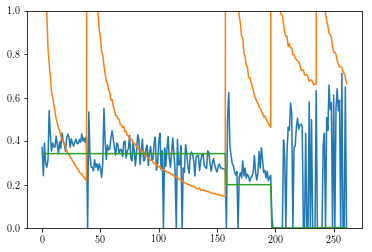

In [63]:
plt.plot(ydata)
#plt.plot(fitt)
#plt.plot(1-np.array(MOdepth)/(0.4*ustartotal/1e-4))
#plt.plot(1-np.array(MOdepth)/(1.4*ustartotal/np.sqrt(1e-4*np.sqrt(1e-6))))
plt.plot((1.4*ustartotal/1e-4)/(Htotal))
plt.plot(0.06*ustartotal/1e-4/MOdepth)
#plt.plot(5*np.array(MOdepth)/Htotal)
plt.ylim(0,1)
#plt.plot(1-(1+S2a)/(0.4*0.4*np.sqrt(S2a))*(1e-4)/np.sqrt(1e-5))

In [ ]:
np.mean(0.06*ustartotal/1e-4/MOdepth)

In [ ]:
plt.plot(1/test)

In [ ]:
mask = MOdepth/(ydata*Htotal)<1
plt.plot(ydata[mask]*Htotal[mask])
#np.array(test).shape
#plt.plot(1-(-0.043*np.array(vpwpscale)[mask]+5.9377e-6)*np.array(test)[mask]/(np.array(Ball)[mask]))
#plt.plot((1-a*np.array(test)[mask]*np.array(scale)[mask]/np.array(Ball)[mask]))
plt.plot( (1+0.7*test[mask]*scale[mask]/Ball[mask])*Htotal[mask])
    #plt.ylim(0,2)

In [ ]:
plt.plot(np.array(ydata))
plt.plot(1+np.array(test)/4000)

In [ ]:
nz, nf = np.array(vbf).shape
colors = ['r', 'g', 'b', 'k', 'c', 'm']
plt.figure(figsize=(10,10))
ci = 0
for i in range(0, 30,10):
    plt.plot(vbf[:,i], z/Htotal[i], color=colors[ci])
    plt.plot(0, ydata[i], color=colors[ci], marker='x')
    ci += 1
plt.grid()   
plt.ylim((0, 2))
plt.xlim((-1e-9, 1e-9))

In [ ]:
#plt.plot(qmean, z)
#plt.plot(qsmooth,z)
#plt.axvline(Qo*0.2)

ts = -1
V = 0.1
#plt.plot(qflux[0,:],z)
plt.plot(-test[ts]*vpwpa[ts,:], z)
plt.plot(vbf[:,ts], z)
#plt.plot(-test[ts]*vpwpa[ts,:]+vbf[:,ts], z, linestyle='dashed')
plt.axhline(Htotal[ts])
plt.axhline(ydata[ts]*Htotal[ts], color='r')
plt.axhline(MOdepth[ts], color='y')
plt.axvline(ustartotal[ts]**2*test[ts])
#plt.plot(ustartotal[ts]**2*test[ts]*(1-enttotal[ts]*z/Htotal[ts]), z)
#plt.plot(test[ts]*np.array(vpwpscale[ts])*(1-z/Htotal[ts]), z)
wstar = np.array(vpwpscale)[ts]/(test[ts]*ydata[ts]*Htotal[ts])
#plt.plot(2.5e-2*test[ts]*np.array((V - test[ts]*Htotal[ts])*wstar)*(1-enttotal[ts]*z/Htotal[ts]), z)
plt.axvline(2.5e-2*test[ts]*np.array((V - test[ts]*Htotal[ts])*wstar)*0.5, color='g')

#plt.plot(0.5*test[ts]*np.array(ustartotal[ts]*wstar)*(1-enttotal[ts]*z/Htotal[ts]), z)
#plt.plot(1.2e-2*test[ts]*np.array(test[ts]*Htotal[ts]*wstar)*(1-enttotal[ts]*z/Htotal[ts]), z)
plt.axvline(0.35*test[ts]*np.array(wstar*ustartotal[ts]), color='y')

plt.grid()
plt.title(MOdepth[ts]/Htotal[ts])
plt.ylim(0, 50)

In [ ]:
vpwpa = np.array(vpwpa)
vpwpa.shape

In [ ]:
np.mean(S2a/(1+S2a))


In [ ]:
bz.shape
plt.plot(np.mean(bz[-18:, :]+N**2, axis=0), z)
plt.axhline(hn)
plt.axhline(H)

In [ ]:
wbz = np.gradient(np.array(vbfa), axis=1)/np.gradient(z)
wbzz = np.gradient(wbz, axis=1)/np.gradient(z)
plt.plot(np.array(vbfa)[-1,:], z)
plt.plot(qm[-1,:], z)
plt.axhline(ydata[-1]*Htotal[-1])
plt.axhline(Htotal[-1])

In [ ]:
qm.shape

In [ ]:
# fit optimal in terms of h (rather than h/H)
# poptl, pcov = optimize.curve_fit(fitH, factor[:], ydata[:]*Htotal, p0=14)
# print(poptl[0])

mask = ydata<100
en = np.array(enttotal)
popt, pcov = optimize.curve_fit(fitn(en[mask], Htotal[mask]), factor[mask], ydata[mask]*Htotal[mask], p0=14)
print(popt[0])

print(np.corrcoef(np.array(hntotal), y = fitn(en, Htotal)(np.array(factor), popt[0]))**2)
# plt.scatter(np.array(hntotal)/np.array(Htotal), fitH(np.array(factor), poptl[0]))
fitt = fitn(en, Htotal)(np.array(factor), popt[0])
plt.scatter(np.array(hntotal), fitt)


plt.plot(np.array(hntotal), np.array(hntotal))

plt.grid()
plt.figure()
plt.plot(ydata)
plt.plot(fitt/Htotal)

# plt.plot(fitH(factor, poptl[0]))

In [ ]:
plt.figure()
plt.plot(ydata*Htotal)
plt.plot(fitn(en, Htotal)(factor, popt[0]))
#plt.plot(fitn(en, Htotal)(factor, 14))


In [ ]:
ci

In [ ]:
test.shape

In [ ]:
vbf

In [ ]:
nz, nf = np.array(vbf).shape
colors = ['r', 'g', 'b', 'k', 'c', 'm', 'r', 'g', 'b']
plt.figure(figsize=(10,10))
for i in range(8, nf, 10):
    plt.plot(vbf[:,i], z, color=plt.cm.jet(i/nf))
    #plt.plot(0, fitH(factor[i], popt[0]), marker='x')
    plt.plot(0, fitn(np.array([enttotal[i]]), Htotal[i])(np.array([factor[i]]), popt[0]), marker='o', color=plt.cm.jet(i/nf))
    plt.gca().set_prop_cycle(None)
    plt.plot(0, ydata[i]*Htotal[i],  marker='x',color=plt.cm.jet(i/nf))

plt.grid()   
plt.ylim((0, 50))
plt.xlim((-2e-10, 2e-10))
#lt.xlim((-1e-9, 1e-9))

In [ ]:

#plt.plot(fitH(factor, popt[0]))

## Test one specific run

In [ ]:
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5' #Ruan case F
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
b = f['tasks']['b'] # Perturbation buoyancy
v = f['tasks']['v'] # Along-slope direction
vbfr = f['tasks']['VBFr']
#vbfrot = f['tasks']['VBFrotated']
z = v.dims[2][0][:]
time = v.dims[0][0][:]
q = f['tasks']['PV']
qm = np.mean(q, axis=1)
Qo = 1e-4*N**2
vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
# Calculate BEk
tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])

# Calculate h

nt = time.size

h_H = []
Hq = []
x1 = []
for i in range(0, nt, 12):
    ti = range(i, i+12)
    vsmooth = np.mean(vbfr[ti,0,:]-0*1e-4*(bz[ti,:] + N**2), axis=0)
    #inds = np.where(np.diff(np.sign(vsmooth)) <0)[0]
    #inds = np.where(vsmooth>0)[-1] # shallowest point where w'b'>0

    qmean = integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)
    #indq = np.where(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z)>0)[0][0] 
    #inds = np.where(inds<=indq)[0]
    inds = np.where(np.logical_and(vsmooth>0, qmean<=0))[0]
    if inds.size == 0:
        inds = [0]
    inds = [inds[-1]]
    
    hn = z[inds[0]]
# Calculate H
    nt = Bek.shape[0]

   

    # Try a direct calculation of H and entrainment
    indq = np.where(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z)>0)[0][0] 
    H = z[indq] - z[0]
    ent = np.mean(vbfr[ti,0,indq] - 1e-4*(bz[ti,indq] + N**2))

    Beka = np.mean(Bek[ti])
    Ha = H
    ha = hn
    factorPartial = Beka**2/(Ha*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3
    ydataPartial = ha/Ha     
    entPartial = 1 + ent/Beka
    
    h_H.append(ydataPartial)
    Hq.append(Ha)
    x1.append(fitn(np.array([entPartial]))(np.array([factorPartial]), popt[0]))
    
x1 = np.array(x1)
h_H = np.array(h_H)
Hq = np.array(Hq)

In [ ]:
x1.append(fitn(np.array([entPartial]))(np.array([factorPartial]), popt[0]))

In [ ]:
plt.plot(h_H*Hq)
plt.plot( x1[:,0]*Hq)

In [ ]:
x1.shape

In [ ]:
Hq.shape

In [ ]:
plt.plot(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)/z/Qo, z/Ha)
plt.plot(np.mean(qm[ti,:], axis=0)/Qo, z/Ha)
plt.axhline(z[indq]/Ha)

# plt.xlim(-2, 2)

In [ ]:
plt.plot(vsmooth, z/Ha)
plt.axhline(z[inds[0]]/Ha)

In [ ]:
plt.plot(integrate.cumtrapz(z, x=z, initial=z[0]), z)

In [ ]:
plt.plot(np.mean(GSP[ti,0,:], axis=0), z)
# plt.plot(np.mean(vbf))
plt.axhline(z[inds[0]])

In [ ]:
ts= 20
plt.plot(vpwpa[ts], z)
plt.plot(vbfa[ts], z)

plt.axhline(Htotal[ts], color='g')
plt.axhline(ydata[ts]*Htotal[ts])
plt.axhline(fitn(np.array([enttotal[ts]]), Htotal[ts])(np.array([factor[ts]]), popt[0]), color='r')
plt.ylim(0, 90)

In [ ]:
plt.scatter(ydata*Htotal, np.array(test)*Htotal)
plt.title(np.corrcoef(ydata, np.array(test)))

In [ ]:
plt.plot(np.mean(wq[ti,0,:]-0*1e-4*np.gradient(qm[ti,:], axis=-1)/np.gradient(z), axis=0), z/Ha)

In [ ]:
q.shape

In [ ]:
qm.shape

In [ ]:
plt.plot(Htotal)

In [ ]:
plt.plot(Htotal)

In [ ]:
wq.shape

In [ ]:
plt.plot(ustartotal)